# Analyze Taylor Swift Lyrics with Python

### Try some of these resources for extra help as you work:

* [View the Analyze Taylor Swift Lyrics with Python Cheatsheet](https://www.codecademy.com/learn/case-study-analyze-taylor-swift-lyrics/modules/analyze-taylor-swift-lyrics/cheatsheet)
* Learn more about analyzing text in [Apply Natural Language Processing with Python](https://www.codecademy.com/learn/paths/natural-language-processing)

[View the solution notebook](./solution.html)

[The original dataset was curated by Jan Llenzl Dagohoy and published on Kaggle](https://www.kaggle.com/datasets/thespacefreak/taylor-swift-song-lyrics-all-albums)


In [1]:
%matplotlib inline

import pandas as pd
import string
import seaborn as sns
import matplotlib.pyplot as plt
import collections
import nltk
from nltk.tokenize import word_tokenize
from nltk.sentiment import SentimentIntensityAnalyzer


### 1. Load the dataset

After running the first cell to load all necessary libraries, we need to load our dataset. 
* Using pandas, load the dataset taylor_swift_lyrics_2006-2020_all.csv and save it as `lyrics`. 
* Inspect the first few rows.
* Use `.info()` to determine how many rows there are, check for missing values, and check the variable types.


*Note that we added the lyrics from the new Midnights album. If you want to inspect the lyrics from that album, you can find them in the file tree. Click on the Jupyter logo in the upper left corner and you can see all the files.* 

*Use "taylor_swift_lyrics_2006-2022_all.csv" in the `pd.read_csv()` function below to also analyze Midnights.*

In [2]:
# load dataset
lyrics = pd.read_csv("taylor_swift_lyrics_2006-2020_all.csv")

#inspect the first few rows
lyrics.head()

,album_name,track_title,track_n,lyric,line
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5


In [3]:
#get info about the DataFrame
lyrics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8358 entries, 0 to 8357
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   album_name   8358 non-null   object
 1   track_title  8358 non-null   object
 2   track_n      8358 non-null   int64 
 3   lyric        8358 non-null   object
 4   line         8358 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 326.6+ KB


<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

The Taylor Swift lyrics dataset consists of comprehensive data on the lyrics from her albums 2020. There are no missing values. We can see the lyric details along the column axis and each lyric along the row axis. We can find the name  of each album, the track, and the line in which the lyric appears. We do not have year associated with this dataset. 

</details>

### 2. Add essential data

We know that we want to explore her use of terms over years, but this dataset doesn't have years. We can either merge a dataset or manually create a new column. We have created a function for you that fills in the year based on the album name. 

* Apply this function to the `lyrics` DataFrame to create a new column.

In [4]:
# get a list of all the albums in this collection
print(lyrics.album_name.unique())

['Fearless (Taylor’s Version)' 'Red (Deluxe Edition)' '1989 (Deluxe)'
 'reputation' 'Taylor Swift' 'folklore (deluxe version)' 'Lover'
 'evermore (deluxe version)' 'Speak Now (Deluxe)']


In [5]:
# this is a function to map the name of the album to the year it was released
def album_release(row):  
    if row['album_name'] == 'Taylor Swift':
        return '2006'
    elif row['album_name'] == 'Fearless (Taylor’s Version)':
        return '2008'
    elif row['album_name'] == 'Speak Now (Deluxe)':
        return '2010'
    elif row['album_name'] == 'Red (Deluxe Edition)':
        return '2012'
    elif row['album_name'] == '1989 (Deluxe)':
        return '2014'
    elif row['album_name'] == 'reputation':
        return '2017'
    elif row['album_name'] == 'Lover':
        return '2019'
    elif row['album_name'] == 'evermore (deluxe version)':
        return '2020'
    #ok, we know folklore was actually released in Dec 2020, but this will make our analysis easier
    elif row['album_name'] == 'folklore (deluxe version)':
        return '2021'
    #this is slightly differently formatted because the album name is recorded two ways.
    elif 'midnights' in row['album_name']:
        return '2022'
    
    return 'No Date'

# apply the function to the album
lyrics['album_year'] = lyrics.apply(lambda row: album_release(row), axis=1)

# inspect the first few rows of the DataFrame
lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008


### 3. Clean the lyric text

To accurately count keyword mentions, we need to: 
* lowercase everything, 
* remove punctuation, 
* and exclude stop words. 

Save this in a new column called `clean_lyric` and check to be sure you have what you expect by viewing the first few rows.

In [6]:
#lowercase
lyrics['clean_lyric'] = lyrics['lyric'].str.lower()

#remove punctuation
lyrics['clean_lyric']= lyrics['clean_lyric'].str.replace('[^\w\s]','')
lyrics.head()

#remove stopwords (see the next cell for illustration)
#create a small list of English stop words, feel free to edit this list
stop = ['the', 'a', 'this', 'that', 'to', 'is', 'am', 'was', 'were', 'be', 'being', 'been']


#there are three steps in one here - explained below
#we make a list of words with `.split()`
#then we remove all the words in our list
#then we join the words back together into a string
lyrics['clean_lyric'] = lyrics['clean_lyric'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout way
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when its just rained
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres glow off pavement you walk me car
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in middle of parking lot yeah


### The next cells are for illustration only

In [7]:
#see what `.split()` does
lyrics['clean_lyric_list'] = lyrics['clean_lyric'].apply(lambda x: x.split())
print(lyrics.head())

                    album_name                  track_title  track_n  \
0  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
1  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
2  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
3  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
4  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   

                                               lyric  line album_year  \
0                    There's something 'bout the way     1       2008   
1             The street looks when it's just rained     2       2008   
2  There's a glow off the pavement, you walk me t...     3       2008   
3  And you know I wanna ask you to dance right there     4       2008   
4             In the middle of the parking lot, yeah     5       2008   

                                      clean_lyric  \
0                       theres something bout way   
1               street

In [8]:
#see what `.join()` does
lyrics['clean_lyric_list_rejoined'] = lyrics['clean_lyric_list'].apply(lambda x: ' '.join(x))
print(lyrics.head())

                    album_name                  track_title  track_n  \
0  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
1  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
2  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
3  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
4  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   

                                               lyric  line album_year  \
0                    There's something 'bout the way     1       2008   
1             The street looks when it's just rained     2       2008   
2  There's a glow off the pavement, you walk me t...     3       2008   
3  And you know I wanna ask you to dance right there     4       2008   
4             In the middle of the parking lot, yeah     5       2008   

                                      clean_lyric  \
0                       theres something bout way   
1               street

In [9]:
#remove those illustration columns
lyrics.drop(['clean_lyric_list', 'clean_lyric_list_rejoined'], axis=1, inplace=True)
print(lyrics.head())

                    album_name                  track_title  track_n  \
0  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
1  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
2  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
3  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   
4  Fearless (Taylor’s Version)  Fearless (Taylor’s Version)        1   

                                               lyric  line album_year  \
0                    There's something 'bout the way     1       2008   
1             The street looks when it's just rained     2       2008   
2  There's a glow off the pavement, you walk me t...     3       2008   
3  And you know I wanna ask you to dance right there     4       2008   
4             In the middle of the parking lot, yeah     5       2008   

                                      clean_lyric  
0                       theres something bout way  
1               street l

In [10]:
#there are many pre-built lists of stopwords, including one from sklearn.
#Most exclude too many words to be appropriate for song lyric analysis.
from sklearn.feature_extraction import text
skl_stop = text.ENGLISH_STOP_WORDS
print(skl_stop)

frozenset({'whoever', 'seems', 'very', 'any', 'something', 'once', 'those', 'eleven', 'for', 'themselves', 'elsewhere', 'throughout', 'mill', 'you', 'un', 'fill', 'be', 'serious', 'much', 'becomes', 'become', 'front', 'thin', 'why', 'six', 'least', 'hereby', 'thence', 'both', 'two', 'because', 'seeming', 'noone', 'everything', 'one', 'either', 'beyond', 'keep', 'another', 'where', 'describe', 'whereas', 'further', 'during', 'yourselves', 'take', 'forty', 'move', 'otherwise', 'show', 'then', 'what', 'all', 'he', 'whole', 'that', 'might', 'under', 'con', 'side', 'wherein', 'again', 'part', 'above', 'nine', 'back', 'or', 'yours', 'afterwards', 'about', 'beforehand', 're', 'to', 'would', 'well', 'indeed', 'hereupon', 'ten', 'yet', 'against', 'before', 'co', 'how', 'due', 'see', 'from', 'get', 'seemed', 'therein', 'into', 'below', 'five', 'anywhere', 'sixty', 'bottom', 'thereupon', 'empty', 'amount', 'thereafter', 'whither', 'top', 'anything', 'whereupon', 'four', 'none', 'name', 'towards',

### 4. Find keyword mentions

Because we are most interested in "midnight", we will first count how many times midnight occurs in Taylor Swift's lyrics. 

* Create a new column to indicate if a lyric has "midnight" in it.
* Check how many times midnight occurrs

In [11]:
#create a new column to reflect if the lyrics contain midnight
lyrics['midnight'] = lyrics['clean_lyric'].str.contains('midnight')
sum(lyrics['midnight'])

9

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

Midnight is not very common -- it only appeared 9 times! 

</details>

### 5. Expand the keyword list

Midnight might not be the only way that Taylor Swift has talked about night. We need to expand our list. We've made a list of night words and day words. Feel free to add or remove words to make the list your own. 
* Create two new columns, one for night words, and one for day words
* Join the lists into a regular expression string using the `.join()` function and the `|` to indicate "or"
* Check the clean lyrics for the presence of words in the regular expression you just made.
* Count how many times the words appeared and print them to the screen
* Inspect the first few rows of the lyrics DataFrame to be sure it looks as you expect

In [12]:
#night, day, and other time-related words
night = ['night','midnight', 'dawn', 'dusk', 'evening', 'late', 'dark', '1am', '2am', '3am', '4am']
day = ['day', 'morning', 'light', 'sun', 'dawn', 'noon', 'golden', 'bright']
time = ['today', 'tomorrow', 'yesterday']

#create a regular expression string for each list of words
night_regex = '|'.join(night)
day_regex = '|'.join(day)
time_regex = '|'.join(time)

#create a new column for each category of words
lyrics['night'] = lyrics['clean_lyric'].str.contains(night_regex)
lyrics['day'] = lyrics['clean_lyric'].str.contains(day_regex)
lyrics['time'] = lyrics['clean_lyric'].str.contains(time_regex)

#count the number of times each category of word appears in the lyrics
night_count = sum(lyrics['night'])
day_count = sum(lyrics['day'])
time_count = sum(lyrics['time'])

#print the count of each word category
print("night words: ", night_count)
print("day words: ", day_count)
print("time words: ", time_count)

#inspect the first few rows
lyrics.head()

night words:  240
day words:  363
time words:  35


,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,night,day,time
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout way,False,False,False,False
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when its just rained,False,False,False,False
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres glow off pavement you walk me car,False,False,False,False
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in middle of parking lot yeah,False,False,False,False


<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

Taylor Swift has referenced time alot, there's enough mentions for us to potentially spot some trends. Also, she has mentioned day far more than night. This might be because of the search terms, so we might consider revisiting the list. Or it could be because she is actually more focused on day and light than she is on night and dark. 

</details>

# Task Group 2

### 6. Visualize how Taylor Swift's mentions of time have changed over time.

Now that we know that she has referenced time, we can see if that has changed, and if she has been dropping any hints about her upcoming album. 
* Create a new dataframe called `yearly_mentions` that groups her mentions by year, and takes the sum of the other columns. Reset the index on this DataFrame to make it easier to use with matplotlib
* Create a line chart in matplotlib showing the night mentions over time.

In [13]:
#create a new dataframe for yearly mentions that groups mentions by year
yearly_mentions = lyrics.groupby('album_year').sum().reset_index()
yearly_mentions

,album_year,track_n,line,midnight,night,day,time
0,2006,4867,13456,0,19,25,3
1,2008,15644,27793,0,42,65,20
2,2010,8450,27489,0,31,53,4
3,2012,11992,27800,1,48,53,7
4,2014,8424,33546,2,27,41,0
5,2017,7640,33775,3,25,25,0
6,2019,8813,25741,0,22,46,0
7,2020,8443,25712,2,18,38,0
8,2021,6193,16854,1,8,17,1


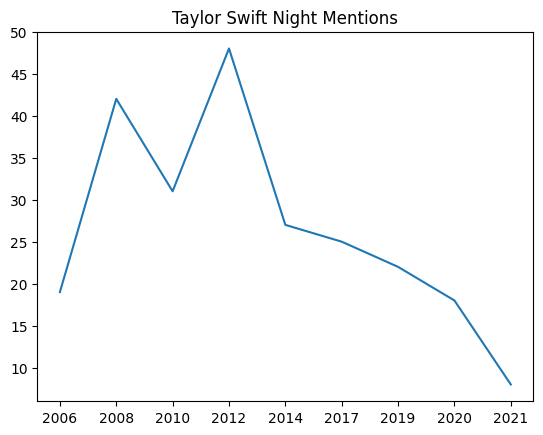

In [14]:
#plot the mentions of night over years
plt.plot(yearly_mentions['album_year'], yearly_mentions['night'])
plt.title("Taylor Swift Night Mentions")
plt.show()

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

It looks like there was a peak in her mentioning night around 2012. It seems like those mentions have become less prevalent over time, with an actual dip in 2019! We had expected midnight to appear more often around then, based on rumors that she plans everything 3 years out.

</details>

### 7. What albums are the most night/day focused?
Now that we have a table of counts, it's very easy to figure out which albums have the most mentions of day or night. But our DataFrame only has the years, not the album names. We need to add those back in.
* Run the code that reinstates the album name for this dataframe.
* Use `.sort_values()` to order the yearly_mentions table and find which year has the most mentions of night.
* Do the same for the day column. 

In [15]:
#reinstate the album name
#read the album_year_name.csv
year_name = pd.read_csv('album_year_name.csv')

#sort both dataframes by year
yearly_mentions.sort_values(by='album_year', ascending=True, inplace=True)
year_name.sort_values(by='album_year', ascending=True, inplace=True)

#add the new column for album name
yearly_mentions['album_name'] = year_name['album_name']

In [16]:
#sort the lyrics by the night column to find the albums with the most night references
yearly_mentions.sort_values(by='night', ascending=False)

,album_year,track_n,line,midnight,night,day,time,album_name
3,2012,11992,27800,1,48,53,7,reputation
1,2008,15644,27793,0,42,65,20,Red (Deluxe Edition)
2,2010,8450,27489,0,31,53,4,1989 (Deluxe)
4,2014,8424,33546,2,27,41,0,Taylor Swift
5,2017,7640,33775,3,25,25,0,folklore (deluxe version)
6,2019,8813,25741,0,22,46,0,Lover
0,2006,4867,13456,0,19,25,3,Fearless (Taylor’s Version)
7,2020,8443,25712,2,18,38,0,evermore (deluxe version)
8,2021,6193,16854,1,8,17,1,Speak Now (Deluxe)


<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

Her most "nightly" album was reputation in 2012, whereas her least nightly album was also the one right before Midnight. Has she been saving all her night-related lyrics for the past 3 years?

</details>

In [17]:
#sort the lyrics by the day column to find the albums with the most day references
yearly_mentions.sort_values(by='day', ascending=False)

,album_year,track_n,line,midnight,night,day,time,album_name
1,2008,15644,27793,0,42,65,20,Red (Deluxe Edition)
2,2010,8450,27489,0,31,53,4,1989 (Deluxe)
3,2012,11992,27800,1,48,53,7,reputation
6,2019,8813,25741,0,22,46,0,Lover
4,2014,8424,33546,2,27,41,0,Taylor Swift
7,2020,8443,25712,2,18,38,0,evermore (deluxe version)
0,2006,4867,13456,0,19,25,3,Fearless (Taylor’s Version)
5,2017,7640,33775,3,25,25,0,folklore (deluxe version)
8,2021,6193,16854,1,8,17,1,Speak Now (Deluxe)


<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

It seems like her older work focused on day much more than her more recent. There was a period of time (2008-2012) when she was really focused on day, but it seems to have become less central to her work more recently. 

</details>

### 8. Compare day to night mentions
* Create another line chart with both the night mentions and the day mentions

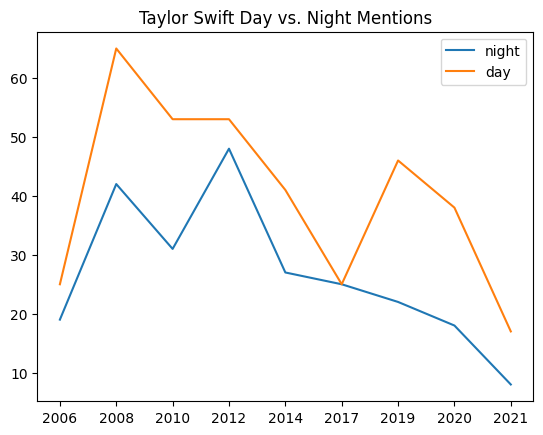

In [18]:
#create a plot with one line showing number of night references by year 
#and another line with the number of day references by year
plt.plot(yearly_mentions['album_year'], yearly_mentions['night'], label = 'night')
plt.plot(yearly_mentions['album_year'], yearly_mentions['day'], label = 'day')
plt.title("Taylor Swift Day vs. Night Mentions")
plt.legend()
plt.show()

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

Well this is interesting. We see a similar dip in referencing time around 2017, but a sharp increase in both 2019 and 2020 to reference day. 

</details>

### 9. Investigate position of day vs. night mentions within albums
Maybe her references to time aren't always about the year that she released the album, but the ebb and flow of the album itself. Let's plot where, within each album, references to day and night occur.

* Create a variable that indicates the position of a lyric within an album. Call this 'position'.
* Create a new dataframe called positional_mentions that groups her mentions by album position, and takes the sum of the other columns. Reset the index on this DataFrame to make it easier to use with matplotlib.
* Create a line chart in matplotlib showing the night and day mentions as a position within the album.

*Remember that you can always print the head of the DataFrame to check your work*

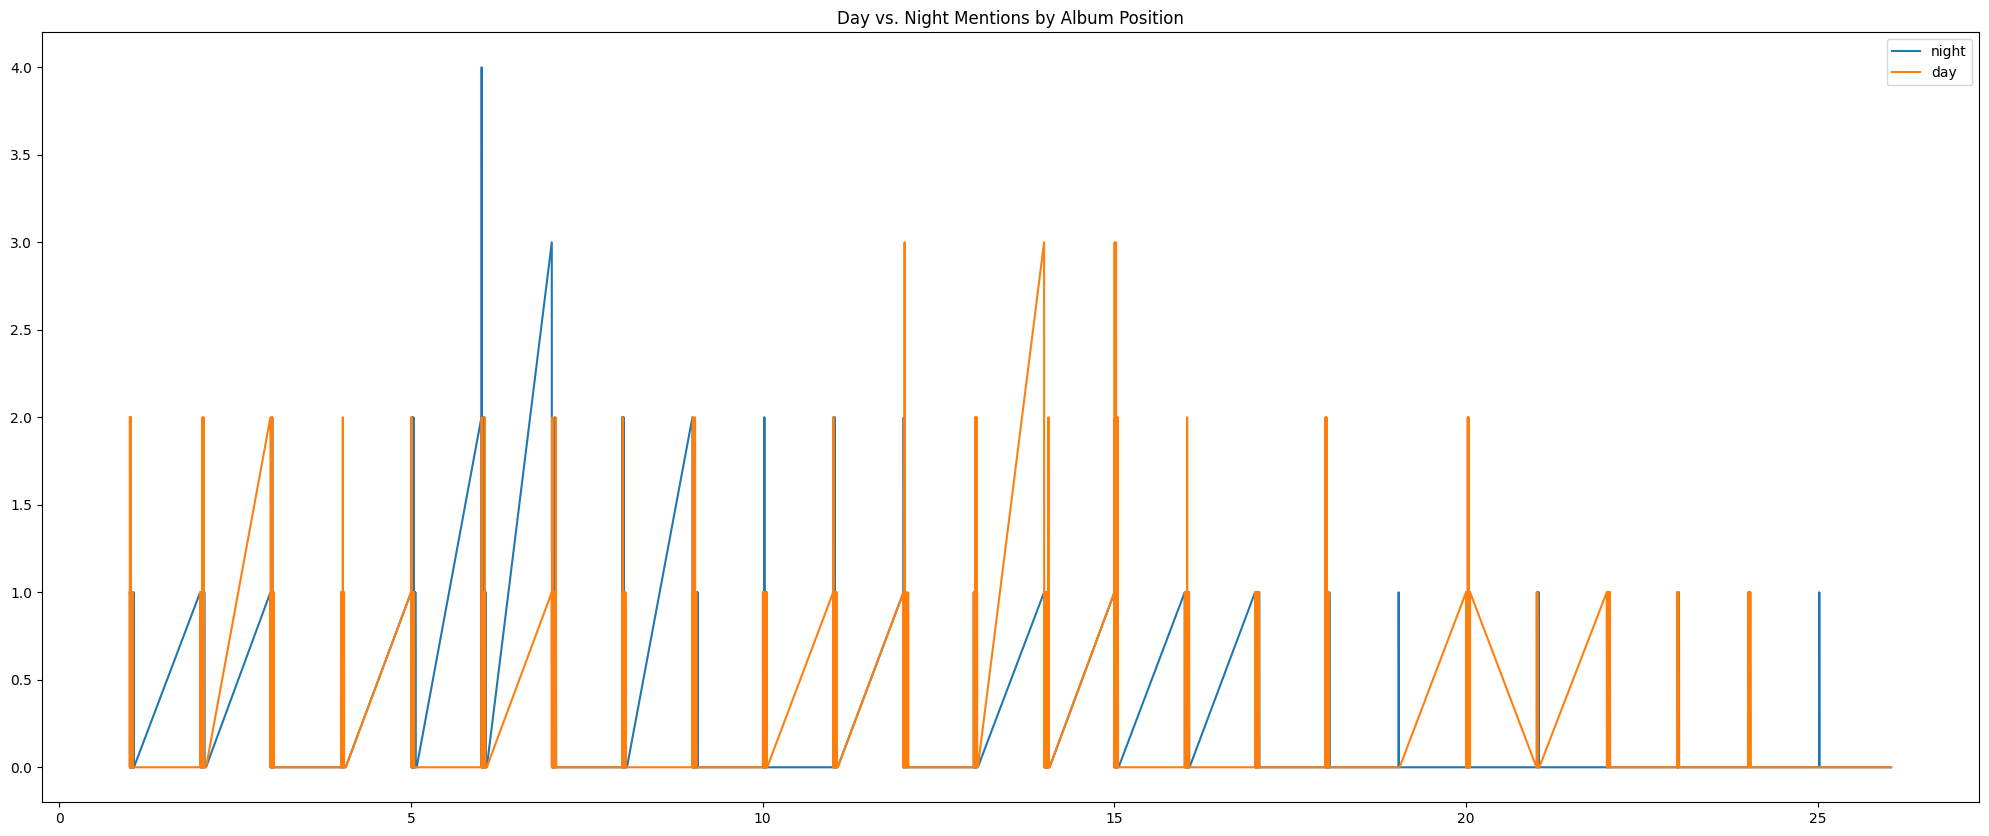

In [19]:
#create a position variable that includes both the track number and line number
lyrics['position'] = lyrics['track_n'] + (lyrics['line']/1000)

#create a new DataFrame that is grouped by position
positional_mentions = lyrics.groupby('position').sum().reset_index()

#increase the size of the plot 
fig = plt.gcf()
fig.set_size_inches(25,10)

#create a plot with two lines to show frequency of day vs. night references by position in the album
plt.plot(positional_mentions['position'], positional_mentions['night'], label = 'night')
plt.plot(positional_mentions['position'], positional_mentions['day'], label = 'day')
plt.legend()
plt.title("Day vs. Night Mentions by Album Position")

plt.show()

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

    Honestly not that much -- we can't see any strong trends here. Best to move on. 
</details>

# Task Group 3

### 10. Tokenize the Lyrics
It's great to know how much she has focused on day and night, but we would also like to do a little more sophisticated analysis. Before we can work with our cleaned lyrics, we will have to tokenize them. Tokenization is a way of breaking up words. There are a variety of wa. The output is a list of words that we can then perform text analysis on.

Split the words on their space

* Run the cell to tokenize the cleaned lyrics.
* Inspect the first few rows of the lyrics DataFrame
* Create a list of all the tokens in the lyrics_tok column into one list
* Use the Counter function from the collections package to count the number of times each word appears
* Sort the resulting dictionary

In [20]:
#run this cell to tokenize the words in the clean_lyric column
lyrics['lyrics_tok'] = lyrics['clean_lyric'].str.split(' ')

In [21]:
#inspect the first few lines
lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,night,day,time,position,lyrics_tok
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout way,False,False,False,False,1.001,"[theres, something, bout, way]"
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when its just rained,False,False,False,False,1.002,"[street, looks, when, its, just, rained]"
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres glow off pavement you walk me car,False,False,False,False,1.003,"[theres, glow, off, pavement, you, walk, me, car]"
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False,1.004,"[and, you, know, i, wanna, ask, you, dance, ri..."
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in middle of parking lot yeah,False,False,False,False,1.005,"[in, middle, of, parking, lot, yeah]"


In [22]:
#determine what words overall are the most frequently used words
#create a list of all the words in the lyrics_tok column
word_list = [word for list_ in lyrics['lyrics_tok'] for word in list_]

#use the counter function to count the number of times each word appears
word_frequency = collections.Counter(word_list)
#sort the word frequencies to find out the most common words she's used. 
word_frequency = sorted(word_frequency.items(), key=lambda x: x[1], reverse=True)
#call the word frequency
word_frequency

[('you', 2835),
 ('i', 2635),
 ('and', 1712),
 ('me', 1063),
 ('it', 931),
 ('in', 887),
 ('my', 816),
 ('your', 623),
 ('of', 592),
 ('but', 540),
 ('all', 531),
 ('im', 501),
 ('we', 498),
 ('like', 488),
 ('on', 467),
 ('know', 456),
 ('so', 422),
 ('oh', 411),
 ('dont', 406),
 ('when', 392),
 ('its', 380),
 ('never', 353),
 ('youre', 343),
 ('just', 339),
 ('for', 306),
 ('now', 305),
 ('with', 302),
 ('love', 295),
 ('what', 284),
 ('up', 272),
 ('out', 270),
 ('back', 267),
 ('time', 261),
 ('cause', 253),
 ('at', 249),
 ('if', 245),
 ('are', 225),
 ('no', 213),
 ('one', 201),
 ('got', 201),
 ('see', 199),
 ('say', 198),
 ('do', 195),
 ('think', 192),
 ('baby', 188),
 ('down', 181),
 ('want', 181),
 ('go', 181),
 ('they', 173),
 ('come', 172),
 ('could', 167),
 ('can', 164),
 ('there', 162),
 ('not', 162),
 ('wanna', 161),
 ('cant', 157),
 ('ill', 156),
 ('right', 155),
 ('said', 146),
 ('have', 146),
 ('yeah', 145),
 ('he', 144),
 ('ever', 140),
 ('would', 140),
 ('had', 134),
 

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

   She mostly talks about you and then herself, while that's not surprising, it also tells us that she's mostly writing about relationships and her realtionships with others. 
</details>

### 11. Analyze Lyric Sentiment

To better understand how she thinks and feels about day and night, we want to know which one she writes about more favorably. 

We are going to use the pre-trained sentiment classifier that comes with NLTK. It's it trained on tweets and therefore best for short text. It return 4 values: positive, negative, neutral, and compound. Compound will be of special interest to us. It is the normalized sum of positive and negative. 

* Run the sample sentiment analyzer cell to see how the SentimentIntensityAnalyzer works.
* Apply the sia sentiment analyzer to the clean_lyric column of the DataFrame with a lambda expression
* Run the cell that transforms the dictionary into columns of the DataFrame

In [23]:
#run this cell to add a package from NLTK for our sentiment analyzer.
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/ccuser/nltk_data...


True

In [24]:
#run this cell to see how the sentiment analyzer works
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("I love Taylor Swift!")

{'neg': 0.0, 'neu': 0.137, 'pos': 0.863, 'compound': 0.7424}

In [25]:
#create a new column called polarity and apply the sia method to the clean_lyric column with a lambda expression
lyrics['polarity'] = lyrics['clean_lyric'].apply(lambda x: sia.polarity_scores(x))
lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,night,day,time,position,lyrics_tok,polarity
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout way,False,False,False,False,1.001,"[theres, something, bout, way]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when its just rained,False,False,False,False,1.002,"[street, looks, when, its, just, rained]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres glow off pavement you walk me car,False,False,False,False,1.003,"[theres, glow, off, pavement, you, walk, me, car]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False,1.004,"[and, you, know, i, wanna, ask, you, dance, ri...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound..."
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in middle of parking lot yeah,False,False,False,False,1.005,"[in, middle, of, parking, lot, yeah]","{'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'comp..."


In [26]:
#run this cell to transform the polarity dictionary into columns of the DataFrame
lyrics[['neg', 'neu', 'pos', 'compound']] = lyrics['polarity'].apply(pd.Series)
lyrics.drop('polarity', axis=1)

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,night,day,time,position,lyrics_tok,neg,neu,pos,compound
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout way,False,False,False,False,1.001,"[theres, something, bout, way]",0.000,1.000,0.000,0.0000
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when its just rained,False,False,False,False,1.002,"[street, looks, when, its, just, rained]",0.000,1.000,0.000,0.0000
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres glow off pavement you walk me car,False,False,False,False,1.003,"[theres, glow, off, pavement, you, walk, me, car]",0.000,1.000,0.000,0.0000
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False,1.004,"[and, you, know, i, wanna, ask, you, dance, ri...",0.000,1.000,0.000,0.0000
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in middle of parking lot yeah,False,False,False,False,1.005,"[in, middle, of, parking, lot, yeah]",0.000,0.694,0.306,0.2960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8353,Speak Now (Deluxe),Superman,17,I'll be right here on the ground,51,2010,ill right here on ground,False,False,False,False,17.051,"[ill, right, here, on, ground]",0.412,0.588,0.000,-0.4215
8354,Speak Now (Deluxe),Superman,17,When you come back down,52,2010,when you come back down,False,False,False,False,17.052,"[when, you, come, back, down]",0.000,1.000,0.000,0.0000
8355,Speak Now (Deluxe),Superman,17,"La, la, la, la, la, la",53,2010,la la la la la la,False,False,False,False,17.053,"[la, la, la, la, la, la]",0.000,1.000,0.000,0.0000
8356,Speak Now (Deluxe),Superman,17,"La, la, la, la, la, la",54,2010,la la la la la la,False,False,False,False,17.054,"[la, la, la, la, la, la]",0.000,1.000,0.000,0.0000


In [27]:
#inspect the first few rows
lyrics.head()

,album_name,track_title,track_n,lyric,line,album_year,clean_lyric,midnight,night,day,time,position,lyrics_tok,polarity,neg,neu,pos,compound
0,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,There's something 'bout the way,1,2008,theres something bout way,False,False,False,False,1.001,"[theres, something, bout, way]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.000,0.000,0.000
1,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,The street looks when it's just rained,2,2008,street looks when its just rained,False,False,False,False,1.002,"[street, looks, when, its, just, rained]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.000,0.000,0.000
2,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"There's a glow off the pavement, you walk me t...",3,2008,theres glow off pavement you walk me car,False,False,False,False,1.003,"[theres, glow, off, pavement, you, walk, me, car]","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.000,0.000,0.000
3,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,And you know I wanna ask you to dance right there,4,2008,and you know i wanna ask you dance right there,False,False,False,False,1.004,"[and, you, know, i, wanna, ask, you, dance, ri...","{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound...",0.0,1.000,0.000,0.000
4,Fearless (Taylor’s Version),Fearless (Taylor’s Version),1,"In the middle of the parking lot, yeah",5,2008,in middle of parking lot yeah,False,False,False,False,1.005,"[in, middle, of, parking, lot, yeah]","{'neg': 0.0, 'neu': 0.694, 'pos': 0.306, 'comp...",0.0,0.694,0.306,0.296


### 12. Corpus Sentiment Analysis

Now that we have sentiment for all of her lyrics, let's learn more about her overall sentiment, as well as how that has change throughout her career. 
* Use the pos, neg, and compound columns to calculate the overall sentiment of her entire collection, and print the result.
* Use the groupby function and matplotlib to visualize the overall sentiment of her albums over time 

In [28]:
#calculate overall sentiment for pos, neg, sentiment
pos = sum(lyrics['pos'])
neg = sum(lyrics['neg'])
compound = sum(lyrics['compound'])

#print the overall sentiments
print("positive: ", pos)
print("negative: ", neg)
print("compound: ", compound)

positive:  1102.1670000000026
negative:  715.9210000000002
compound:  432.74670000000094


<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

   Overall Taylor Swift's lyrics are mostly positive! 
</details>

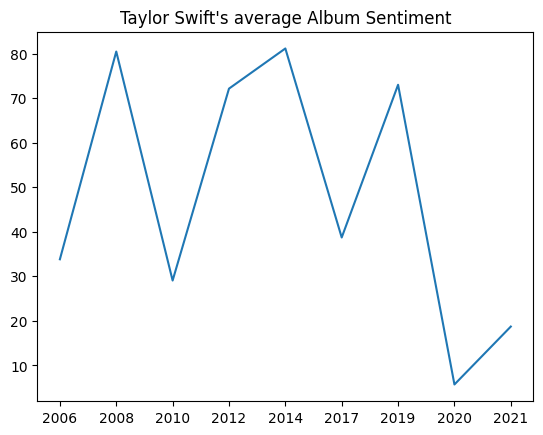

In [29]:
#create a new DataFrame using the groupby method for the album_year
yearly_sentiment = lyrics.groupby('album_year').sum().reset_index()
#visualize sentiment over time 
plt.plot(yearly_sentiment['album_year'], yearly_sentiment['compound'])
plt.title("Taylor Swift's average Album Sentiment")
plt.show()

<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

   Her degree of positivity has really fluctuated over time. Her 2020 album was by far the least positive, though all of her albums are actually positive. 
</details>

### 13. Day or Night? Positive or Negative
Finally the big reveal. Does Taylor Swift write more positively about day or night? 
* Create two DataFrames: one for all the lyrics that mention night and one for all the lyrics that mention day.
* Check that each DataFrame has the right number of values with the `len()` function
* Calculate the sentiment for both night and day using the compound value and print them.

In [30]:
#create a DataFrame filtered for only night mentions
night = lyrics[lyrics['night']==True]

#create a DataFrame filtered for only day mentions
day = lyrics[lyrics['day']==True]

#print the length of the night and day DataFrames
print("night: ",len(night))
print("day: ",len(day))

night:  240
day:  363


In [31]:
#calculate the sentiment of each day and night DataFrame from the compound values
night_sentiment = night['compound'].sum()
day_sentiment = day['compound'].sum()

#print the results
print("night sentiment: ", night_sentiment)
print("day_sentiment: ", day_sentiment)

night sentiment:  17.4022
day_sentiment:  25.416800000000002


<details>
    <summary style="display:list-item; font-size:16px; color:blue;"><i>What did we discover in this step? Toggle to check!</i></summary>

She's still overall more positive in her sentiment about day than night! 
    
You have the tools to explore if that sentiment has changed over time, or if her feelings towards night have grown more positive or negative over time. And of course, we would love to see your analysis of her new album, Midnight. Have her feelings changed?
    
    Share your findings in the Codecademy forums! 
</details>